# Generative Adversarial Network Tutorial 01

If you haven't looked at the previous tutorial, definitely check that out first!

In this tutorial, I'll extend the previous work to use more sophisticated networks.  In particular, I'll make the generator a deep convolutional network, and leave the discriminator as a shallow fully connected network.  This ought to produce much better digits that the previous fully connected networks.

## MNIST data set

Again, we'll use the mnist data set here.  See the previous tutorial for some mnist basics.

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/gpu:0"

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17879638355642228747
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11990623847
locality {
  bus_id: 1
}
incarnation: 5354604161520709298
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:02:00.0"
]


In [3]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_images, mnist_labels = mnist.train.next_batch(batch_size=5)

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [40]:
BASE_LEARNING_RATE = 0.00005
BATCH_SIZE=100 # Keep this even
N_INITIAL_FILTERS=1024
LOGDIR="./mnist_dcgan_logs/filters_{}_lr_{}".format(N_INITIAL_FILTERS, BASE_LEARNING_RATE)
RESTORE=False
TRAINING=False


Additionally, let's make sure we have the same graph by defining it:

In [41]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real images and random noise, so make a placeholder for both.  Additionally, based on this blog post (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/) I add random gaussian noise to the real and fake images as they are fed to the discriminator to help stabalize training.  



In [42]:
with tf.device(default_device):
    with g.as_default():
        # Input noise to the generator:
        noise_tensor = tf.placeholder(tf.float32, [None, 10*10], name="noise")
#         fake_input   = tf.reshape(noise_tensor, (tf.shape(noise_tensor)[0], 10,10, 1))
        fake_input   = noise_tensor
    

        # Placeholder for the discriminator input:
        real_flat  = tf.placeholder(tf.float32, [None, 784], name='x')
        real_images  = tf.reshape(real_flat, (tf.shape(real_flat)[0], 28, 28, 1))

        # We augment the input to the discriminator with gaussian noise
        # This makes it harder for the discriminator to do it's job, preventing
        # it from always "winning" the GAN min/max contest
        real_noise = tf.placeholder(tf.float32, [None, 28, 28, 1], name="real_noise")
        fake_noise = tf.placeholder(tf.float32, [None, 28, 28, 1], name="fake_noise")

        real_images = real_noise + real_images


Notice how the input tensors (noise_tensor, real_images) are shaped in the 'flattened' way: (N/2, 100) for noise, (N/2, 784) for real images.  This lets me input the mnist images directly to tensorflow, as well as the noise.  They are then reshaped to be like tensorflow images (Batch, H, W, Filters).

### Image Discriminator:

Make a function to build the discriminator, using fully connected networks.  Note that a convolutional layer with the stride equal to the image size *is* a fully connected layer.

This is unchanged from the previous tutorial.

In [44]:
def build_discriminator(input_tensor, is_training=True, reuse=False):
    # Use scoping to keep the variables nicely organized in the graph.
    # Scoping is good practice always, but it's *essential* here as we'll see later on
    with tf.variable_scope("mnist_discriminator", reuse=reuse):

        # Downsample with strided convolutions, use a few layers of convolutions:
        x = tf.layers.conv2d(input_tensor,
                             32,
                             kernel_size = [5,5],
                             strides=(1, 1),
                             padding='valid',)
        
        # Batch norm, relu:
        x = tf.layers.batch_normalization(x,
                                          training=is_training,
                                          trainable=True,
                                          name="batch_norm_1")
        
        x = tf.nn.relu(x)
        
        # Downsample convolution with stride 2:
        x = tf.layers.conv2d(x,
                             64,
                             kernel_size=[3,3],
                             strides=[2,2],
                             padding='valid',
                             name="conv2d_downsample_1")
        
        # Batch norm, relu:
        x = tf.layers.batch_normalization(x,
                                          training=is_training,
                                          trainable=True,
                                          name="batch_norm_2")
        
        x = tf.nn.relu(x)
        
        # Downsample convolution with stride 2:
        x = tf.layers.conv2d(x,
                             128,
                             kernel_size=[3,3],
                             strides=[2,2],
                             padding='valid',
                             name="conv2d_downsample_2")
        
        
        # Apply a 1x1 convolutoin and do global average pooling:
        x = tf.layers.batch_normalization(x,
                                          training=is_training,
                                          trainable=True,
                                          name="batch_norm_3")
        
        x = tf.nn.relu(x)
        
        x = tf.layers.conv2d(x,
                             1,
                             kernel_size=[1,1],
                             strides=[1,1],
                             padding='valid',
                             name="conv2d1x1_downsample")
        
                                          
        # Pooling operation:
        x = tf.layers.average_pooling2d(x,
                                        pool_size=[5,5],
                                        strides=[1,1],
                                        name ='final_pooling')
        
        
            
        # Since we want to predict "real" or "fake", an output of 0 or 1 is desired.  sigmoid is perfect for this:
        x = tf.nn.sigmoid(x, name="discriminator_sigmoid")
        #Reshape this to bring it down to just one output per image:
        x = tf.reshape(x, (-1,))
        return x

In [45]:
with tf.device(default_device):
    with g.as_default():
        real_image_logits = build_discriminator(real_images, is_training=TRAINING, reuse=False)

In [46]:
print real_image_logits.get_shape()

(?,)


Now we can define a function to generate random images from noise:

This function has been transformed into a deeper convolutional neural network.

In [47]:
def build_generator(input_tensor, n_initial_filters=512, is_training=True):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_generator"):

        # Map the input vector to the first convolutional space:
        # It's 10x10x1, we want to get to 4x4x512
        x = tf.layers.dense(input_tensor, 4*4*n_initial_filters, name="project")
        print x.get_shape()
        x = tf.reshape(x, (-1, 4, 4, n_initial_filters), name="reshape")
        
        print x.get_shape()
        
        # Apply batch norm, relu, and upsampling:
        x = tf.layers.batch_normalization(x,
                                center=False,
                                scale=False,
                                training=True,
                                trainable=True,
                                name="batch_norm_1")
        
        x = tf.nn.relu(x, name="relu_1")

        # Upsample with a transposed convolution:
        x = tf.layers.conv2d_transpose(x,
                                       int(0.5*n_initial_filters),
                                       kernel_size=[2,2],
                                       strides=(2, 2),
                                       name="conv2d_transpose_1")

        # Apply batch norm, relu, and upsampling again:
        x = tf.layers.batch_normalization(x,
                                center=False,
                                scale=False,
                                training=True,
                                trainable=True,
                                name="batch_norm_2")
        
        x = tf.nn.relu(x, name="relu_2")
        
        # Upsample with a transposed convolution:
        x = tf.layers.conv2d_transpose(x,
                                       int(0.25*n_initial_filters),
                                       kernel_size=[2,2],
                                       strides=(2, 2),
                                       name="conv2d_transpose_2")
                                    
        
        # Apply batch norm, relu, and upsampling again:
        x = tf.layers.batch_normalization(x,
                                center=False,
                                scale=False,
                                training=True,
                                trainable=True,
                                name="batch_norm_3")
        
        x = tf.nn.relu(x, name="relu_3")
                           
        # Upsample with a transposed convolution:
        x = tf.layers.conv2d_transpose(x,
                                       int(0.125*n_initial_filters),
                                       kernel_size=[2,2],
                                       strides=(2, 2),
                                       name="conv2d_transpose_3")

        # Apply batch norm, relu, and upsampling again:
        x = tf.layers.batch_normalization(x,
                                center=False,
                                scale=False,
                                training=True,
                                trainable=True,
                                name="batch_norm_4")
        
        x = tf.nn.relu(x, name="relu_4")
        
        # Map the space onto a 28x28x1 region:
        x = tf.layers.conv2d(x,
                             1,
                             kernel_size=[5,5],
                             strides=[1,1],
                             name="final_conv2d")
        
         
        # The final non linearity applied here is to map the images onto the [-1,1] range.
        x = tf.nn.tanh(x, name="generator_tanh")
        return x

In [48]:
with tf.device(default_device):
    with g.as_default():
        fake_images = build_generator(fake_input, n_initial_filters=N_INITIAL_FILTERS, is_training=TRAINING) + fake_noise

(?, 16384)
(?, 4, 4, 1024)


In [49]:
print fake_noise.get_shape()
print fake_input.get_shape()

(?, 28, 28, 1)
(?, 100)


We also need to be able to run the discriminator on the fake images, so set that up too.  Since it trains on both real and fake images, set reuse=True here:

In [50]:
with tf.device(default_device):
    with g.as_default():
        fake_image_logits = build_discriminator(fake_images, reuse=True)

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the generator and discriminator seperately:

In [15]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            #Discriminator loss on real images (classify as 1):
            d_loss_total = -tf.reduce_mean(tf.log(real_image_logits) + tf.log(1. - fake_image_logits))

            # This is the adverserial step: g_loss tries to optimize fake_logits to one,
            # While d_loss_fake tries to optimize fake_logits to zero.
            g_loss = -tf.reduce_mean(tf.log(fake_image_logits))

            # This code is useful if you'll use tensorboard to monitor training:
#             d_loss_summary = tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
#             d_loss_summary = tf.summary.scalar("Discriminator_Fake_Loss", d_loss_fake)
            d_loss_summary = tf.summary.scalar("Discriminator_Total_Loss", d_loss_total)
            d_loss_summary = tf.summary.scalar("Generator_Loss", g_loss)


It's also useful to compute accuracy, just to see how the training is going:

In [16]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            accuracy_real  = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_logits), 
                                                             tf.ones_like(real_image_logits)), 
                                                    tf.float32))
            accuracy_fake  = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_image_logits), 
                                                             tf.zeros_like(fake_image_logits)), 
                                                    tf.float32))

            total_accuracy = 0.5*(accuracy_fake +  accuracy_real)

            # Again, useful for tensorboard:
            acc_real_summary = tf.summary.scalar("Real_Accuracy", accuracy_real)
            acc_real_summary = tf.summary.scalar("Fake_Accuracy", accuracy_fake)
            acc_real_summary = tf.summary.scalar("Total_Accuracy", total_accuracy)

### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [17]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            # Make sure the optimizers are only operating on their own variables:

            all_variables      = tf.trainable_variables()
            discriminator_vars = [v for v in all_variables if v.name.startswith('mnist_discriminator/')]
            generator_vars     = [v for v in all_variables if v.name.startswith('mnist_generator/')]


            discriminator_optimizer = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.9).minimize(
                d_loss_total, global_step=global_step, var_list=discriminator_vars)
            generator_optimizer     = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.9).minimize(
                g_loss, global_step=global_step, var_list=generator_vars)


### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [18]:
with tf.device(default_device):
    with g.as_default():
        tf.summary.image('fake_images', fake_images, max_outputs=4)
        tf.summary.image('real_images', real_images, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [19]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [ ]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        if not RESTORE:
            sess.run(tf.global_variables_initializer())
            train_writer.add_graph(sess.graph)
            saver = tf.train.Saver()
        else: 
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)



        print "Begin training ..."
        # Run training loop
        for i in xrange(50000):
            step = sess.run(global_step)

            # Receive data (this will hang if IO thread is still running = this
            # will wait for thread to finish & receive data)
            epoch = (1.0*i*BATCH_SIZE) / 60000.
#             sigma = max(0.75*(10. - epoch) / (10), 0.05)
            
            # Update the generator:
            # Prepare the input to the networks:
            fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, 100))
            real_data, label = mnist.train.next_batch(BATCH_SIZE)
            real_data = 2*(real_data - 0.5)
#             real_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
#             fake_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))

            real_noise_addition = numpy.zeros((BATCH_SIZE, 28,28, 1))
            fake_noise_addition = numpy.zeros((BATCH_SIZE, 28,28, 1))

            # Update the discriminator:
            [generated_mnist, _] = sess.run([fake_images, 
                                            discriminator_optimizer], 
                                            feed_dict = {noise_tensor : fake_input,
                                                         real_flat : real_data,
                                                         real_noise: real_noise_addition,
                                                         fake_noise: fake_noise_addition})

            # Update the generator:
            fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, 100))
#             real_data, label = mnist.train.next_batch(BATCH_SIZE)
#             real_data = 2*(real_data - 0.5)
#             real_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
#             fake_noise_addition = numpy.random.normal(scale=sigma,size=(BATCH_SIZE,28*28))
            fake_noise_addition = numpy.zeros((BATCH_SIZE, 28, 28, 1))

            
            [ _ ] = sess.run([generator_optimizer], 
                feed_dict = {noise_tensor: fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})
            
            # Run a summary step:
            [summary, g_l, d_l, acc] = sess.run(
                [merged_summary, g_loss, d_loss_total, total_accuracy],
                feed_dict = {noise_tensor : fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})


            train_writer.add_summary(summary, step)

            if step != 0 and step % 500 == 0:
                saver.save(
                    sess,
                    LOGDIR+"/checkpoints/save",
                    global_step=step)


            # train_writer.add_summary(summary, i)
            # sys.stdout.write('Training in progress @ step %d\n' % (step))
            if step % 50 == 0:
                print 'Training in progress @ epoch %g, g_loss %g, d_loss %g accuracy %g' % (epoch, g_l, d_l, acc)


As a last step, let's load this network back into memory and generate a few fake images for visualization.  As you'll see, this network does "OK" but not amazingly well.  In the next post, we'll see a deep convolutional network that does much better at generating images.

In [51]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
        print "Restoring model from {}".format(latest_checkpoint)
        saver = tf.train.Saver()
        saver.restore(sess, latest_checkpoint)


        # We only need to make fake data and run it through the 'fake_images' tensor to see the output:
        
        fake_input = numpy.random.normal(loc=0, scale=1, size=(BATCH_SIZE, 100))
        fake_noise_addition = numpy.zeros((BATCH_SIZE, 28, 28,1))

        [generated_images] = sess.run(
                [fake_images], 
                feed_dict = {noise_tensor: fake_input,
                            fake_noise: fake_noise_addition})


Restoring model from ./mnist_dcgan_logs/filters_1024_lr_5e-05/checkpoints/save-99500
INFO:tensorflow:Restoring parameters from ./mnist_dcgan_logs/filters_1024_lr_5e-05/checkpoints/save-99500


Reshape to make it easier to draw:

In [52]:
generated_images = numpy.reshape(generated_images, (-1, 28, 28))

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

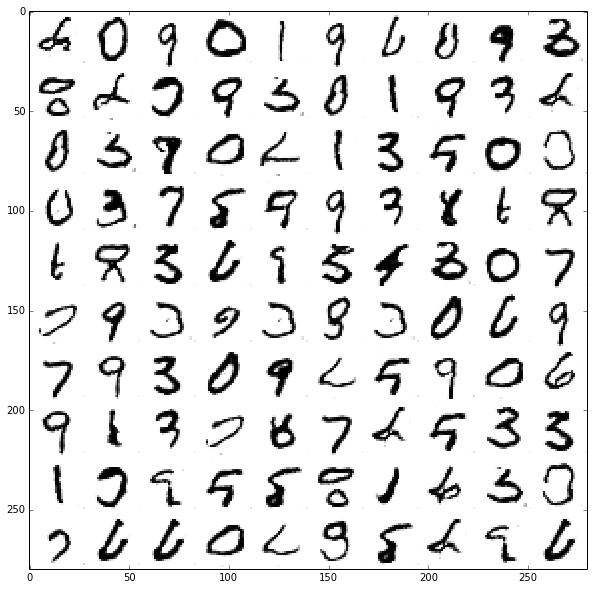

In [56]:

# Tile together lots of digits to see how the network is doing:
final_image = numpy.zeros((280, 280))
for i in range(10):
    for j in range(10):
        index = numpy.random.randint(BATCH_SIZE)
        final_image[i*28:(i+1)*28, j*28:(j+1)*28] = generated_images[index].reshape(28, 28)
        
fig = plt.figure(figsize=(10,10))
plt.imshow(final_image, cmap="Greys", interpolation="none")
plt.show()

Once again, it's just OK. I still think we can do better, but at least it's a demonstration of DCGAN.